In [1]:
!pip install ../dist/rekomenda-0.1.0-py3-none-any.whl --quiet

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import time

from rekomenda.utils import load_movielens_data, find_movie_by_title, evaluate_model
from rekomenda.als import OptimizedLatentFactorALS, LatentFactorALS
from rekomenda.analyser import ALSRecommendationAnalyzer

In [3]:
RATINGS_PATH = '../ml-32m/ratings.csv'
MOVIES_PATH = '../ml-32m/movies.csv'

In [4]:
train_csr, train_csc, test_data, item_id_to_name, movie_id_to_idx = load_movielens_data(ratings_path=RATINGS_PATH, movies_path=MOVIES_PATH)

Loading MovieLens data with chunked processing...
Loading movie metadata...
Loaded 87585 movies

First pass: Collecting unique users and items...
  Processed 5,000,000 ratings...
  Processed 10,000,000 ratings...
  Processed 15,000,000 ratings...
  Processed 20,000,000 ratings...
  Processed 25,000,000 ratings...
  Processed 30,000,000 ratings...
Found 200,948 unique users
Found 84,432 unique items
Total ratings: 32,000,204

Creating ID mappings...

Second pass: Loading ratings and creating train/test split...
  Processed 5,000,000 ratings...
  Processed 10,000,000 ratings...
  Processed 15,000,000 ratings...
  Processed 20,000,000 ratings...
  Processed 25,000,000 ratings...
  Processed 30,000,000 ratings...

Concatenating chunks...
Train: 25,601,564 ratings (80.0%)
Test: 6,398,640 ratings (20.0%)

Creating training sparse matrices...
Matrix: 200948 users × 80229 items
Sparsity: 0.159%

✓ Data loaded successfully with chunked processing
✓ Memory efficient: Processed 32,000,204 ratings

In [5]:
train_als_model = LatentFactorALS(lambda_reg=0.1, n_factors=10)

In [6]:
start = time.time()
train_als_model.fit(train_csr, train_csc, n_iterations=50)
end = time.time()

print(f'Total time taken: {end - start}')

Iteration 1/50 - RMSE: 0.8177, NLL: 8689624.0000
Iteration 2/50 - RMSE: 0.7684, NLL: 7684624.0000
Iteration 3/50 - RMSE: 0.7396, NLL: 7126713.0000
Iteration 4/50 - RMSE: 0.7237, NLL: 6826442.5000
Iteration 5/50 - RMSE: 0.7144, NLL: 6651095.5000
Iteration 6/50 - RMSE: 0.7087, NLL: 6543190.0000
Iteration 7/50 - RMSE: 0.7050, NLL: 6471841.5000
Iteration 8/50 - RMSE: 0.7024, NLL: 6421447.5000
Iteration 9/50 - RMSE: 0.7005, NLL: 6384058.0000
Iteration 10/50 - RMSE: 0.6991, NLL: 6355413.5000
Iteration 11/50 - RMSE: 0.6980, NLL: 6332953.0000
Iteration 12/50 - RMSE: 0.6971, NLL: 6315024.0000
Iteration 13/50 - RMSE: 0.6965, NLL: 6300518.0000
Iteration 14/50 - RMSE: 0.6959, NLL: 6288666.5000
Iteration 15/50 - RMSE: 0.6955, NLL: 6278896.0000
Iteration 16/50 - RMSE: 0.6951, NLL: 6270756.0000
Iteration 17/50 - RMSE: 0.6949, NLL: 6263899.5000
Iteration 18/50 - RMSE: 0.6946, NLL: 6258060.5000
Iteration 19/50 - RMSE: 0.6944, NLL: 6253032.5000
Iteration 20/50 - RMSE: 0.6943, NLL: 6248655.0000
Iteration

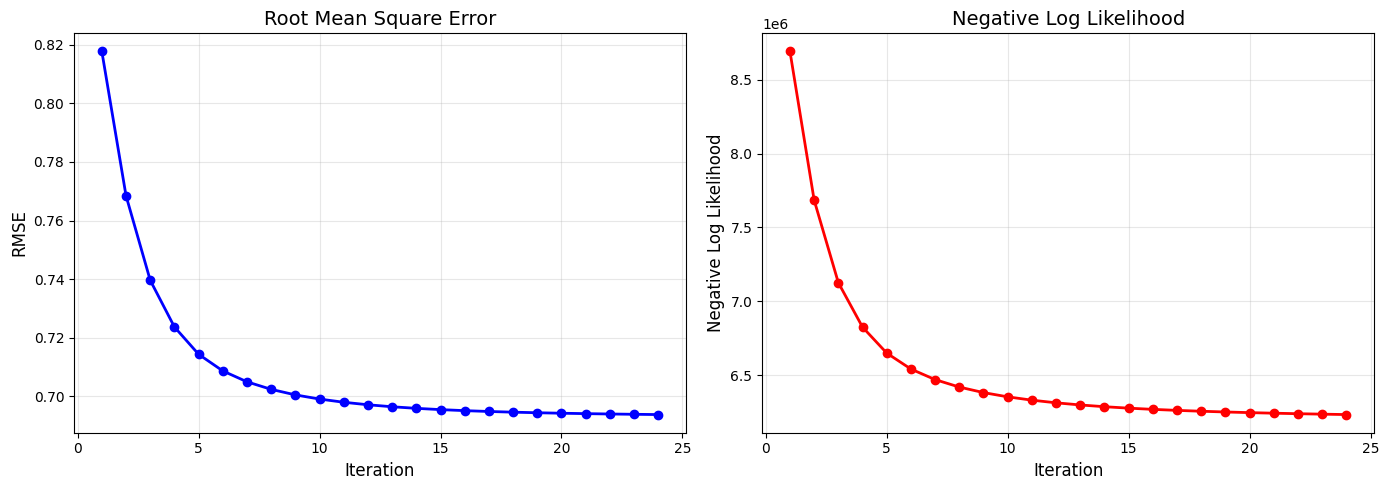

In [8]:
train_als_model.plot_metrics(output='pics/test-model.pdf')

In [18]:
test_users, test_items, test_ratings = test_data

In [9]:
print(len(test_users), train_csr.num_items, )

6398640 80229


In [10]:
test_metrics = evaluate_model(train_als_model, test_users, test_items, test_ratings)


Evaluating on test set...


IndexError: index 80548 is out of bounds for axis 0 with size 80229

In [9]:
analyser = ALSRecommendationAnalyzer(model=train_als_model, item_id_to_name=item_id_to_name)

In [10]:
lotr_matches = find_movie_by_title("Lord of the Rings", item_id_to_name)
if lotr_matches:
    print("\n\nTest 1: Lord of the Rings Fan")
    print("-" * 80)
    fellowship_id, fellowship_name = lotr_matches[0]
    other_lotr_ids = [item_id for item_id, _ in lotr_matches[1:3]]
    
    analyser.test_recommendation_quality(
        seed_movie_id=fellowship_id,
        seed_movie_name=fellowship_name,
        seed_rating=5.0,
        expected_similar_ids=other_lotr_ids,
        top_k=10
    )



Test 1: Lord of the Rings Fan
--------------------------------------------------------------------------------

RECOMMENDATION TEST: User who gave '"Lord of the Rings' a 5.0/5

Top 10 Recommendations:
--------------------------------------------------------------------------------
 1. Christmas Carol: The Movie (2001)                  (predicted: 7.91)
 2. A Creepshow Animated Special (2020)                (predicted: 6.99)
 3. I Start Counting (1970)                            (predicted: 6.97)
 4. "Prince and the Showgirl                           (predicted: 6.87)
 5. The Wyvern Mystery (2000)                          (predicted: 6.73)
 6. The Seven Days (2008)                              (predicted: 6.66)
 7. Dave Attell: Captain Miserable (2007)              (predicted: 6.62)
 8. Murattu Kalai (1980)                               (predicted: 6.56)
 9. Internet Famous (2016)                             (predicted: 6.51)
10. Mischief (1985)                                    (pre

In [11]:
sw_matches = find_movie_by_title("Star Wars", item_id_to_name)
if sw_matches:
    print("\n\nTest 2: Star Wars Fan")
    print("-" * 80)
    sw_id, sw_name = sw_matches[0]

    analyser.test_recommendation_quality(
        seed_movie_id=sw_id,
        seed_movie_name=sw_name,
        seed_rating=5.0,
        top_k=10
    )



Test 2: Star Wars Fan
--------------------------------------------------------------------------------

RECOMMENDATION TEST: User who gave 'Star Wars: Episode IV - A New Hope (1977)' a 5.0/5

Top 10 Recommendations:
--------------------------------------------------------------------------------
 1. Mathu Vadalara (2019)                              (predicted: 6.24)
 2. Sioux Ghost Dance (1894)                           (predicted: 6.24)
 3. Christmas Carol: The Movie (2001)                  (predicted: 6.15)
 4. The Wyvern Mystery (2000)                          (predicted: 6.15)
 5. Marvel Studios: Expanding the Universe (2019)      (predicted: 6.13)
 6. 36 China Town (2006)                               (predicted: 5.93)
 7. Room in Rome (Habitación en Roma) (2010)           (predicted: 5.90)
 8. Boniface's Holiday (1965)                          (predicted: 5.88)
 9. Bone Tomahawk (2015)                               (predicted: 5.88)
10. "Sex                                    

In [12]:
polarizing = analyser.find_polarizing_movies(top_k=20)
for rank, (item_id, norm, name) in enumerate(polarizing, 1):
    print(f"{rank:2d}. {name:60s} | Norm: {norm:.4f}")
    
print("\n\nTop 20 Most Polarizing Movies (by combined metric):")
print("-" * 80)
stats = analyser.compute_rating_statistics_fast(train_csc, top_k=20)
# print(stats.columns)
for i, stat in enumerate(stats, 1):
    print(stat)
    print(i)
    print(f"{i:2d}. {stat['item_name']:50s} | n_ratings={stat['n_ratings']:5d} | "
            f"std={stat['rating_std']:.3f} | norm={stat['factor_norm']:.3f} | "
            f"polarization={stat['polarization_score']:.4f}")
    

 1. Pouic-Pouic (1963)                                           | Norm: 8.2603
 2. "Funuke Show Some Love                                       | Norm: 7.5939
 3. Castle of the Banned Lovers (1956)                           | Norm: 7.0402
 4. Frankenstein Reborn! (1998)                                  | Norm: 6.4254
 5. "Place Promised in Our Early Days                            | Norm: 6.4095
 6. George Best: All By Himself (2016)                           | Norm: 6.1129
 7. iGirlfriend (2017)                                           | Norm: 6.0302
 8. The Prisoner (1955)                                          | Norm: 6.0117
 9. Confessions of a Shopaholic (2009)                           | Norm: 5.9895
10. The Making of 'The Young Ones' (2007)                        | Norm: 5.9067
11. Foreign Fields (2000)                                        | Norm: 5.9032
12. Stalingrad (2013)                                            | Norm: 5.8447
13. Tonight It's Me (2014)              

Filtering to 14686 items with >= 50 ratings
Sampling 100 most polarizing items
Reducing 10D embeddings to 2D using custom PCA...


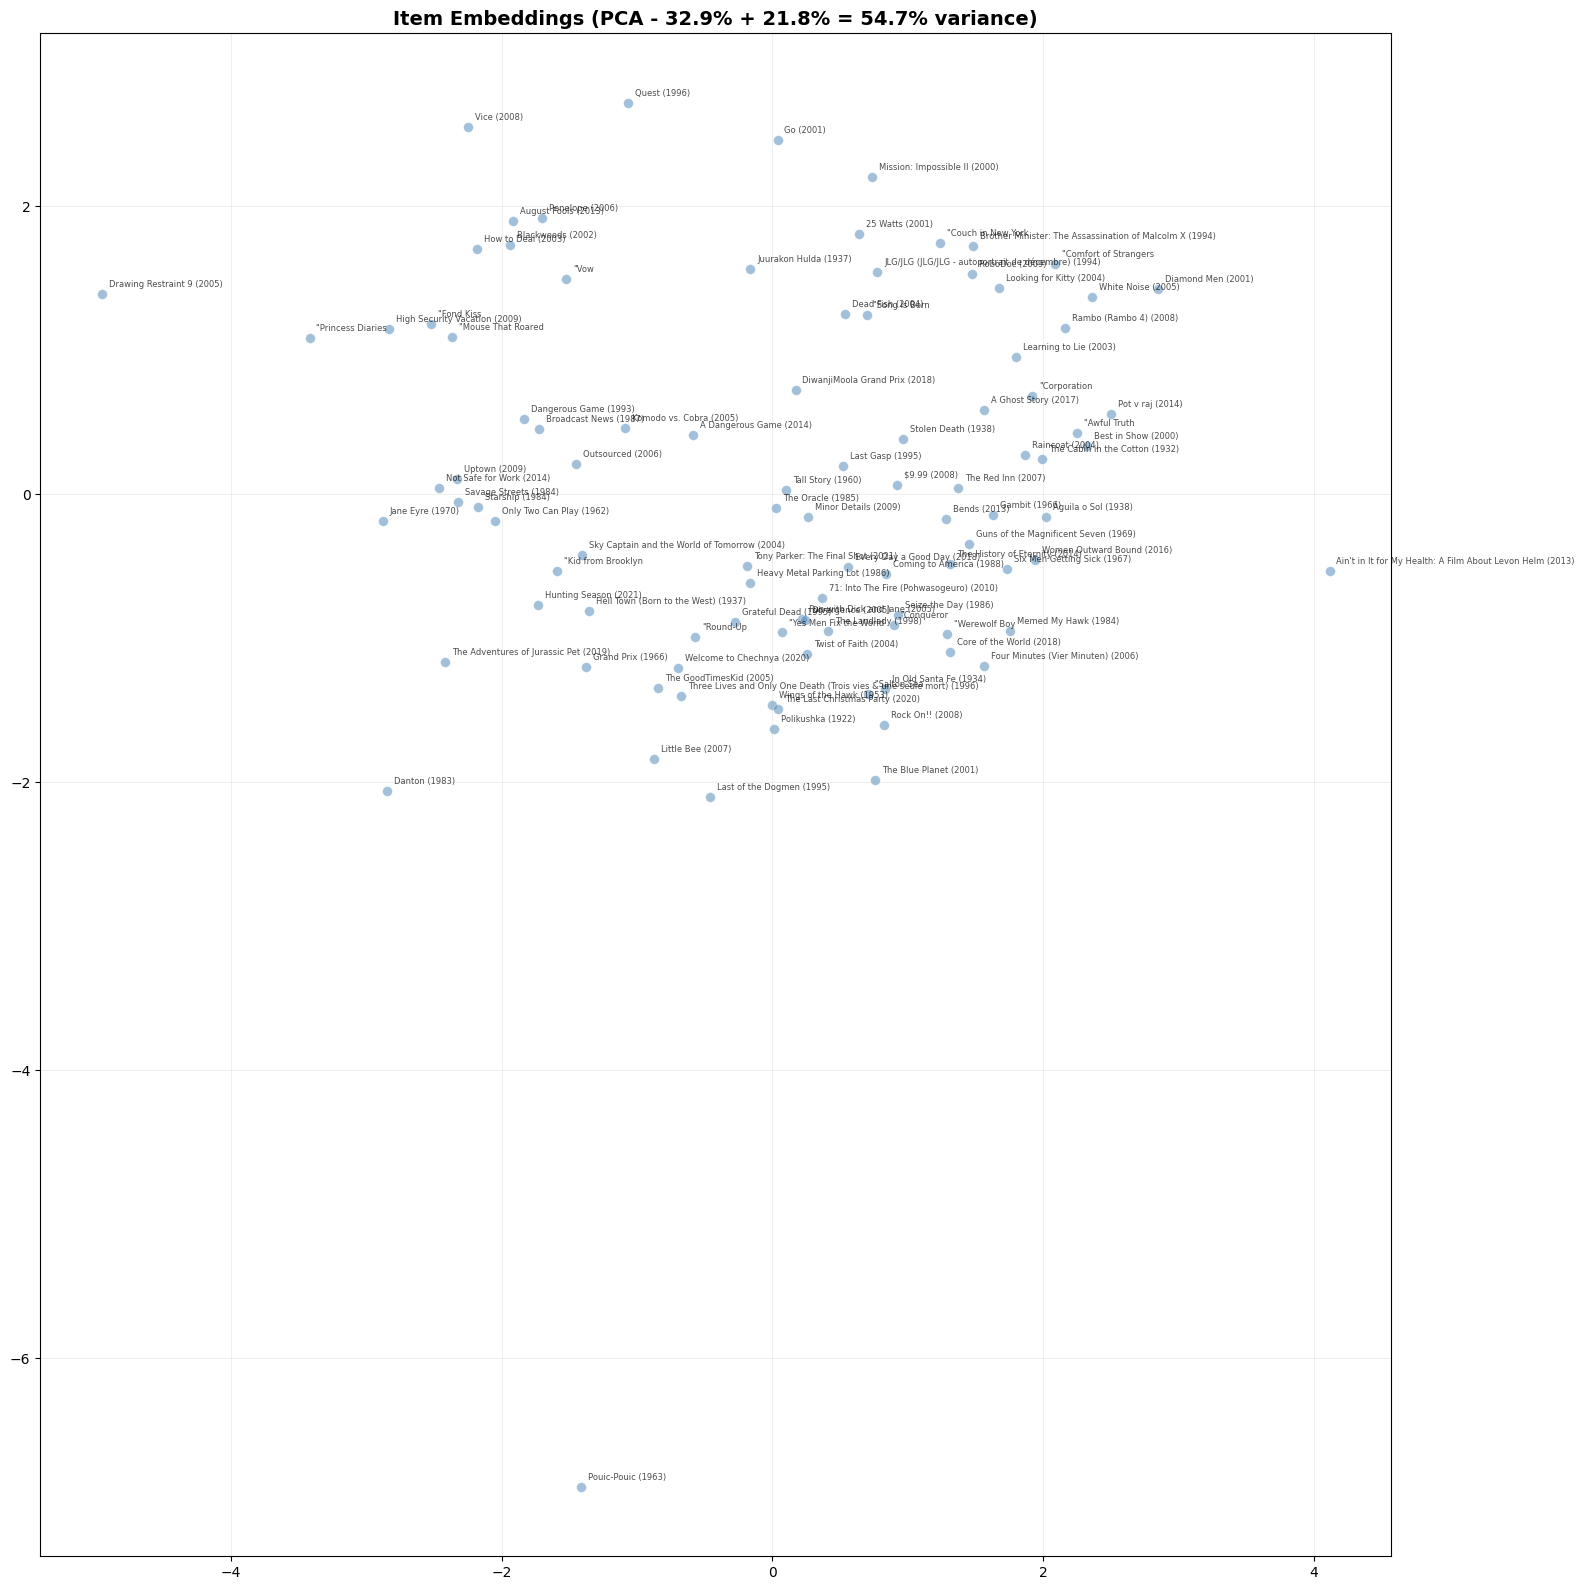

(array([[ 9.65598781e-01,  3.86654875e-01],
        [-5.10920369e-03, -1.46017675e+00],
        [-1.94182849e+00,  1.72859203e+00],
        [-1.08691292e+00,  4.60840697e-01],
        [-2.36508605e+00,  1.09359047e+00],
        [ 5.20641431e-01,  1.95691439e-01],
        [-1.06621805e+00,  2.72035255e+00],
        [ 9.18485948e-01,  6.66467492e-02],
        [ 1.28705875e+00, -9.67281001e-01],
        [ 4.10431175e-01, -9.49366526e-01],
        [-6.96777707e-01, -1.20469939e+00],
        [-2.52379068e+00,  1.18543720e+00],
        [ 5.58314413e-01, -5.03988357e-01],
        [ 1.23782744e+00,  1.74509234e+00],
        [-2.17777898e+00, -8.63103186e-02],
        [-1.44960560e+00,  2.07270365e-01],
        [ 1.63292401e+00, -1.42100847e-01],
        [-2.32813173e+00,  1.09303038e-01],
        [-2.46376708e+00,  4.68117810e-02],
        [ 2.02031096e+00, -1.54664434e-01],
        [ 1.02104335e-02, -1.63165488e+00],
        [ 1.37175848e+00,  4.51027109e-02],
        [ 2.16811195e-01, -8.691

In [13]:
analyser.plot_embedding_scatter(
    output='pics/embedding-plot.pdf',
        n_items=100,
        min_ratings=50,
        csc_matrix=train_csc,
        figsize=(16, 16),
        alpha=0.5,
        show_labels=True,
        label_top_n=30
    )



Plot 2: Highlighting Movie Series
Filtering to 14686 items with >= 50 ratings
Sampling 50 most polarizing items
Reducing 20D embeddings to 2D using custom PCA...


/home/rasheed/Documents/rekomenda/src/rekomenda/analyser.py:297: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)


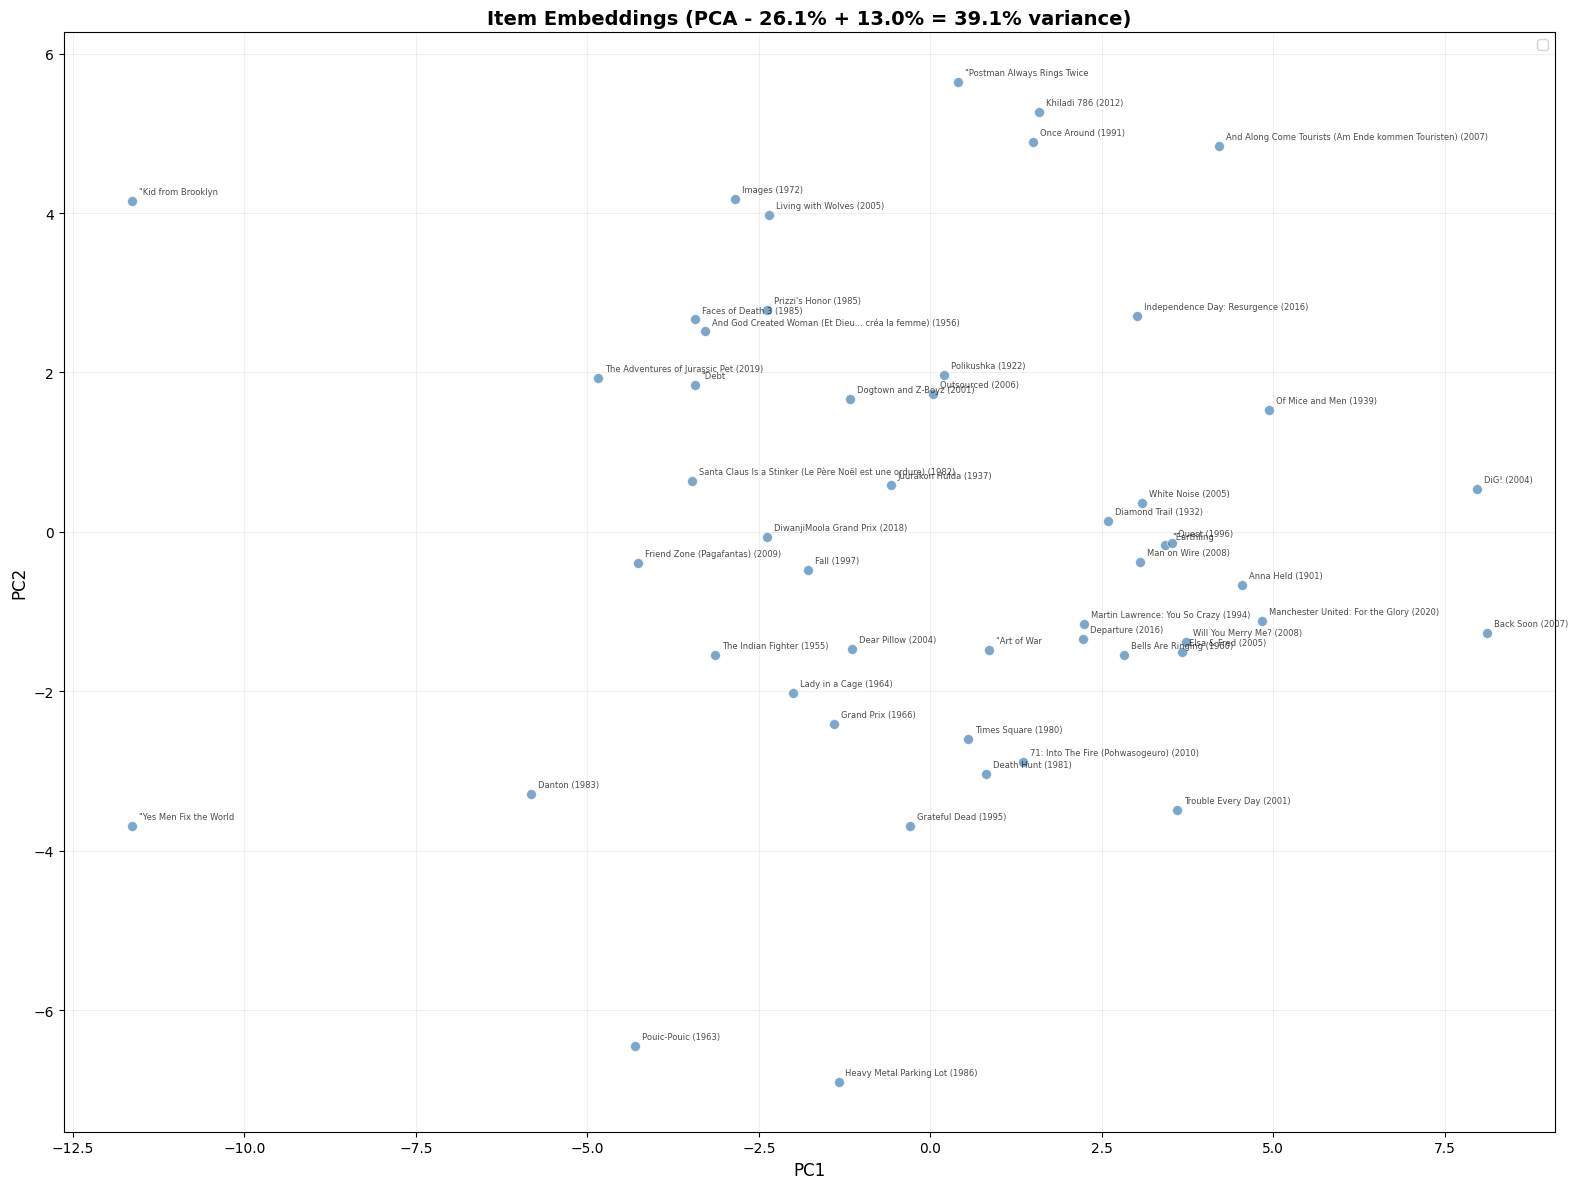

In [27]:
if lotr_matches or sw_matches:
    print("\n\nPlot 2: Highlighting Movie Series")
    highlight_ids = []
    if lotr_matches:
        highlight_ids.extend([item_id for item_id, _ in lotr_matches[:3]])
    if sw_matches:
        highlight_ids.extend([item_id for item_id, _ in sw_matches[:3]])
        
    analyser.plot_embedding_scatter(
        n_items=50,
        highlight_items=highlight_ids,
        min_ratings=50,
        csc_matrix=train_csc,
        figsize=(16, 12),
        alpha=0.7,
        label_top_n=20,
        show_labels=True
    )